In [92]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.metrics import average_precision_score
from tensorflow.keras import backend as K
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'


In [65]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

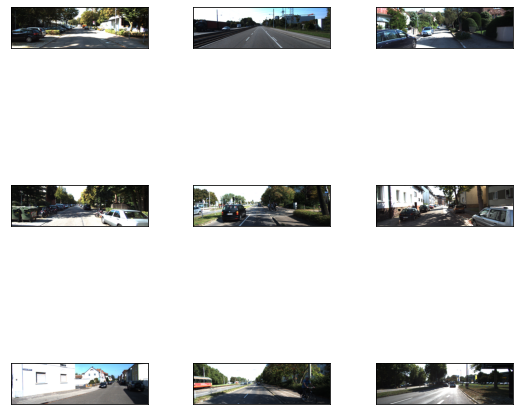

In [66]:
_ = tfds.show_examples(ds_train, ds_info)

In [67]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 2.28,  1.98,  1.8 , -1.76], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.30736   , 0.        , 0.48672   , 0.07442834],
       [0.38952   , 0.20066828, 0.50104   , 0.2676409 ],
       [0.42898667, 0.2857327 , 0.62765336, 0.39367148],
       [0.44138667, 0.6026892 , 0.55744   , 0.61907405]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 1.56,  1.7 ,  4.35],
       [ 1.6 ,  1.79,  3.91],
       [ 3.25,  2.73, 19.74],
       [ 1.75,  0.51,  1.52]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[-15.53,   2.1 ,  18.2 ],
       [-13.43,   2.23,  30.52],
       [ -9.95,   1.91,  41.61],
       [  6.1 ,   1.48,  29.78]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 0, 3, 3])>, 'rotation_y': <tf.Tenso

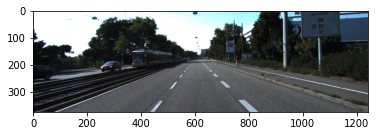

In [68]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

## 데이터 전처리

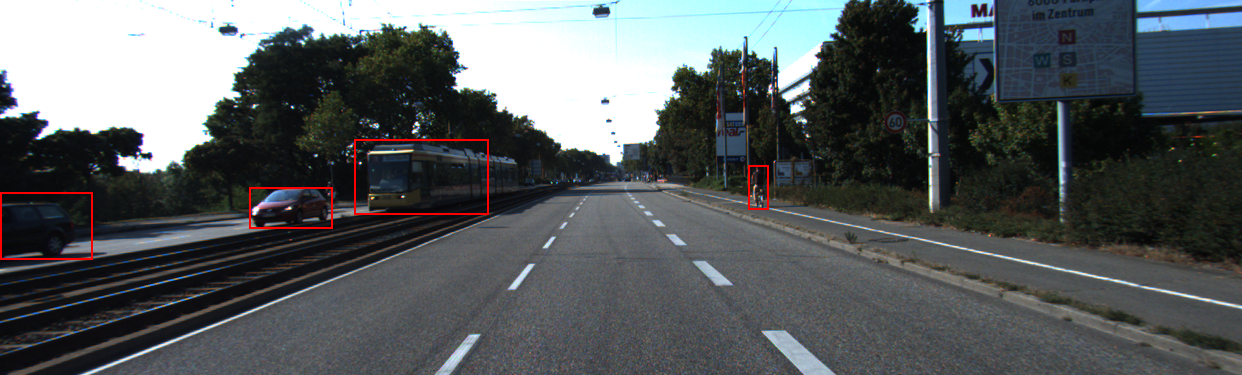

In [69]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
        
    # 바운딩 박스 그리기
    rects = np.stack([x_min,y_min,x_max,y_max] , axis = 1)
    for _rect in rects:
         draw.rectangle(_rect, outline = (255,0,0) , width = 2)
            
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [70]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [71]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [72]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


In [73]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [74]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [75]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


In [76]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [77]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [78]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    

## Model

In [79]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [80]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


In [81]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [82]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


In [83]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

In [84]:
"""
class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='IoU', **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        # 클래스 라벨을 추출
        cls_labels = tf.cast(y_true[:, :, 4], dtype=tf.int32)
        cls_predictions = tf.argmax(y_pred[:, :, 4:], axis=-1)

        # IoU 계산
        for cls in range(self.num_classes):
            # 현재 클래스에 대한 마스크 생성
            cls_mask = tf.equal(cls_labels, cls)
            
            # 해당 클래스에 대한 박스 필터링
            filtered_boxes_labels = tf.boolean_mask(box_labels, cls_mask)
            filtered_boxes_predictions = tf.boolean_mask(box_predictions, cls_mask)

            # 박스가 존재하지 않을 경우 continue
            if tf.shape(filtered_boxes_labels)[0] == 0 or tf.shape(filtered_boxes_predictions)[0] == 0:
                continue

            intersection = self._calculate_intersection(filtered_boxes_labels, filtered_boxes_predictions)
            union = self._calculate_union(filtered_boxes_labels, filtered_boxes_predictions)

            # IoU 계산 및 누적
            iou = tf.where(tf.equal(union, 0.0), 0.0, intersection / (union + tf.keras.backend.epsilon()))
            self.total_iou.assign_add(tf.reduce_sum(iou))
            self.count.assign_add(tf.cast(tf.shape(filtered_boxes_labels)[0], self.dtype))  # 현재 클래스의 박스 수를 count에 추가

    def result(self):
        return self.total_iou / (self.count + tf.keras.backend.epsilon())

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

    def _calculate_intersection(self, boxes1, boxes2):
        x1 = tf.maximum(boxes1[..., 0], boxes2[..., 0])
        y1 = tf.maximum(boxes1[..., 1], boxes2[..., 1])
        x2 = tf.minimum(boxes1[..., 2], boxes2[..., 2])
        y2 = tf.minimum(boxes1[..., 3], boxes2[..., 3])

        intersection_area = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
        return intersection_area

    def _calculate_union(self, boxes1, boxes2):
        area1 = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
        area2 = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
        intersection_area = self._calculate_intersection(boxes1, boxes2)

        union_area = area1 + area2 - intersection_area
        return union_area

"""



"\nclass IoUMetric(tf.keras.metrics.Metric):\n    def __init__(self, num_classes, name='IoU', **kwargs):\n        super(IoUMetric, self).__init__(name=name, **kwargs)\n        self.num_classes = num_classes\n        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')\n        self.count = self.add_weight(name='count', initializer='zeros')\n\n    def update_state(self, y_true, y_pred, sample_weight=None):\n        box_labels = y_true[:, :, :4]\n        box_predictions = y_pred[:, :, :4]\n\n        # 클래스 라벨을 추출\n        cls_labels = tf.cast(y_true[:, :, 4], dtype=tf.int32)\n        cls_predictions = tf.argmax(y_pred[:, :, 4:], axis=-1)\n\n        # IoU 계산\n        for cls in range(self.num_classes):\n            # 현재 클래스에 대한 마스크 생성\n            cls_mask = tf.equal(cls_labels, cls)\n            \n            # 해당 클래스에 대한 박스 필터링\n            filtered_boxes_labels = tf.boolean_mask(box_labels, cls_mask)\n            filtered_boxes_predictions = tf.boolean_mask(box_predic

In [85]:
num_classes = 8
batch_size = 8

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [86]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, 
              optimizer=optimizer)
              



In [87]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)



In [25]:
# 새로운 해상도 설정
new_height = 255
new_width = 255

# 이미지를 리사이즈하는 함수 정의
def resize_image(image, label):
    image = tf.image.resize(image, [new_height, new_width])  # 이미지 크기 조정
    return image, label

# 데이터셋에 리사이즈 함수를 적용
train_dataset_resized = train_dataset.map(resize_image)
val_dataset_resized = val_dataset.map(resize_image)

# 개별 텐서를 Numpy 배열로 변환하여 확인
for image, label in train_dataset_resized.take(1):
    image_np = image.numpy()  # 리사이즈된 이미지 텐서를 Numpy로 변환
    label_np = label.numpy()  # 라벨 텐서를 Numpy로 변환

    print(f"Numpy Image Shape: {image_np.shape}")  # 리사이즈된 이미지의 크기 출력
    print(f"Numpy Label: {label_np}")  # 라벨 출력


Numpy Image Shape: (8, 255, 255, 3)
Numpy Label: [[[  -1.767767     -0.8838835  -107.69921    -111.16495      -1.        ]
  [  -1.4030775    -0.70153874 -108.854454   -112.32019      -1.        ]
  [  -1.1136234    -0.5568117  -110.009705   -113.47545      -1.        ]
  ...
  [  -3.2734041    -8.29831     -10.914642     -9.806827     -1.        ]
  [  -2.5981026    -6.586373    -12.069888    -10.962072     -1.        ]
  [  -1.8999661    -4.7135706   -12.048771     -9.768618     -1.        ]]

 [[  -1.767767     -0.8838835  -107.69921    -111.16495      -1.        ]
  [  -1.4030775    -0.70153874 -108.854454   -112.32019      -1.        ]
  [  -1.1136234    -0.5568117  -110.009705   -113.47545      -1.        ]
  ...
  [  -9.072365     -6.9429336   -15.275198    -12.969008     -1.        ]
  [  -7.2007403    -5.51061     -16.430443    -14.124252     -1.        ]
  [  -0.78766817   -4.6039467   -10.333997    -11.596421     -1.        ]]

 [[  -1.767767     -0.8838835  -107.69921    -1

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./weights_epoch_{epoch}.h5",
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ),
    tf.keras.callbacks.CSVLogger(  
       filename='./training_log.csv',
       append=True,
   )
]

epochs = 20

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)


Epoch 1/20
793/793 [==============================] - 1581s 2s/step - loss: 2.8892 - val_loss: 2.2140

Epoch 00001: saving model to ./weights_epoch_1.h5
Epoch 2/20
793/793 [==============================] - 1523s 2s/step - loss: 1.2423 - val_loss: 1.4529

Epoch 00002: saving model to ./weights_epoch_2.h5
Epoch 3/20
793/793 [==============================] - 1524s 2s/step - loss: 0.8698 - val_loss: 1.2571

Epoch 00003: saving model to ./weights_epoch_3.h5
Epoch 4/20
793/793 [==============================] - 1532s 2s/step - loss: 0.6830 - val_loss: 1.1509

Epoch 00004: saving model to ./weights_epoch_4.h5
Epoch 5/20
793/793 [==============================] - 1526s 2s/step - loss: 0.5632 - val_loss: 1.1591

Epoch 00005: saving model to ./weights_epoch_5.h5
Epoch 6/20
793/793 [==============================] - 1531s 2s/step - loss: 0.4820 - val_loss: 1.0519

Epoch 00006: saving model to ./weights_epoch_6.h5
Epoch 7/20
793/793 [==============================] - 1531s 2s/step - loss: 0.4187

In [149]:
model.build(input_shape=(None, None, None, 3)) 
model.load_weights("./weights_epoch_17.h5")

## IOU metric

In [157]:
# IOU 계산 함수 정의
def compute_iou(y_true, y_pred):
    """Calculate Intersection over Union (IoU) between true and predicted boxes."""
    # y_true와 y_pred는 (batch_size, num_boxes, 4) 형태의 텐서로 가정
    x_true = tf.maximum(y_true[..., 0], y_pred[..., 0])  # x_min
    y_true = tf.maximum(y_true[..., 1], y_pred[..., 1])  # y_min
    x_max = tf.minimum(y_true[..., 2], y_pred[..., 2])   # x_max
    y_max = tf.minimum(y_true[..., 3], y_pred[..., 3])   # y_max

    intersection = tf.maximum(x_max - x_true, 0) * tf.maximum(y_max - y_true, 0)
    area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

    union = area_true + area_pred - intersection
    iou = intersection / union
    return iou

# 모델 평가 함수 정의
def evaluate_model(model, epoch, val_dataset):
    model.load_weights(f"./weights_epoch_{epoch}.h5")

    # validation dataset에서 true boxes와 predicted boxes를 수집합니다.
    y_true = []  # 실제 바운딩 박스 (예: [x_min, y_min, x_max, y_max])
    y_pred = []  # 예측된 바운딩 박스

    for images, true_boxes in val_dataset:  # val_dataset은 검증 데이터셋
        predictions = model(images, training=False)
        decoded_detections = DecodePredictions()(images, predictions)  # 예측된 바운딩 박스 디코딩
        y_true.append(true_boxes)  # 실제 바운딩 박스
        y_pred.append(decoded_detections)  # 예측된 바운딩 박스

    # IoU 계산
    y_true = tf.concat(y_true, axis=0)
    y_pred = tf.concat(y_pred, axis=0)

    iou_scores = compute_iou(y_true, y_pred)
    mean_iou = tf.reduce_mean(iou_scores)
    return mean_iou.numpy()

# 메인 실행 코드
num_classes = 8
batch_size = 8

resnet50_backbone = get_backbone()  # 이미 정의된 백본 모델 가져오기
model = RetinaNet(num_classes, resnet50_backbone)

# IOU 결과를 저장할 딕셔너리
iou_results = {}

# 에포크 1~17 IOU 메트릭 평가
for epoch in range(1, 18):
    model.build(input_shape=(None, None, None, 3))  # 모델 빌드
    iou = evaluate_model(model, epoch, val_dataset)  # val_dataset은 검증 데이터셋
    iou_results[epoch] = iou
    print(f"Epoch {epoch}: IOU = {iou:.4f}")

# 결과를 확인
print("IOU Results for Epochs 1 to 17:", iou_results)

InvalidArgumentError: cannot compute Pack as input #3(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Pack] name: packed

## 시각화

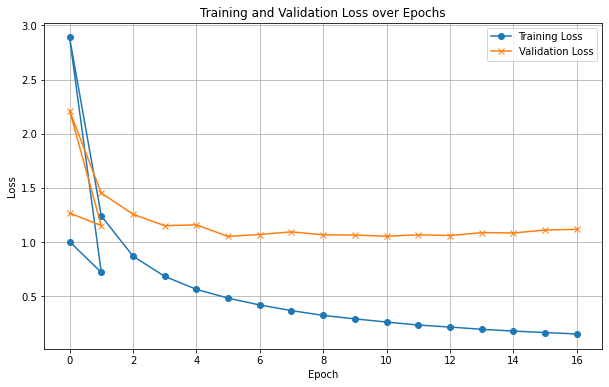

In [93]:
data = pd.read_csv('training_log.csv')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['loss'], label='Training Loss', marker='o')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='x')

# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# 그래프 보여주기
plt.show()

## 결과 확인하기

In [150]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [151]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [152]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [153]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

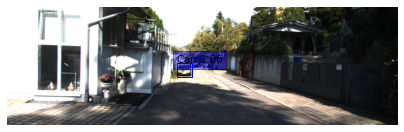

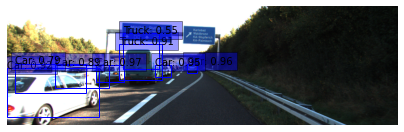

In [154]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [155]:

def self_drive_assist(img_path, size_limit=300):
    # 이미지 로드 및 전처리
    img = Image.open(img_path)
    image_np = np.array(img)
    input_image, ratio = prepare_image(image_np)

    # 객체 탐지 수행
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    # 탐지된 객체 정보 추출
    detected_classes = detections.nmsed_classes[0][:num_detections]
    detected_boxes = detections.nmsed_boxes[0][:num_detections] / ratio

    # 조건 체크
    people_count = np.sum(detected_classes == 1)  # 사람의 클래스 인덱스가 1이라고 가정
    large_vehicle_count = np.sum((detected_boxes[:, 2] - detected_boxes[:, 0] >= size_limit) | 
                                 (detected_boxes[:, 3] - detected_boxes[:, 1] >= size_limit))

    # 정지 조건 확인
    if people_count > 0 or large_vehicle_count > 0:
        return "Stop"
    else:
        return "Go"

In [156]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

80점입니다.


## 회고
metric에 iou값을 넣어서 최적화 시키는 방법이랑 그냥 loss만 Metric를 넣어서 훈련시켰을때 저장된 가중치와 최적화 되는 지점이 다른가..
다른 평가지표를 iou, map 를 저장된 가중치를 통해 게산 시도를 다시 해봐야 겠다.

object 끼리 겹쳐있을 경우 bounding box가 날아가는 Nms의 문제점 때문에 anchor box로 게산을 하게 되었지만 bounding box가 서로 겹치는 경우 각각 동일한 obejct를 탐지할려고 하기 때문에 iou 값이 낮게 나와 정확도가 떨어진거 같다.

사진 속에서 깊숙히 있는 차 class는 정확히 인식이 떨어진다. depth anything 같은 모델을 쌓아서 훈련을 시켜봐야 겠다.

그냥 iou metric에 넣어서 훈련시킬걸.. 
